In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import colorlover as cl
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
import glob, os, re#, pyspark, sqlite3
from IPython.display import Image, HTML
from sqlalchemy import create_engine
#from pyspark.sql import SQLContext
#sqlctx = SQLContext(sc)

import plotly 
import plotly.tools as tls
import plotly.graph_objs as go
ply_credentials = pd.read_csv('../Spotify_Challenge/plotly_credentials.csv')
plotly.tools.set_credentials_file(username=ply_credentials.values[0][0], api_key=ply_credentials.values[0][1])
%matplotlib inline

import scipy.optimize as spo

**Objective 1:** Investigate delays by year, month and airlines between majors hubs

**Objective 2:** Investigate how flights that were delayed at the departure are likely to catch up with time so they arrive on time

**Objective 3:** What are the common reasons for delays

**Objective 4:** What are the reactions of passengers towards delays

#### Definitions:

1. Major carriers: airlines that is still operational since 2010

2. Major airports: top 20 airports to host the highest number of flights over a given year

## Preliminaries

In [3]:
years = [2010,2011,2012,2013,2014,2015,2016]

In [4]:
# initiate a connection to the database
disk_engine = create_engine('sqlite:///../Spotify_Challenge/dbsql.db')
cols = [u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK', u'AIRLINE_ID', u'CARRIER',u'TAIL_NUM', 
        u'FL_NUM', u'ORIGIN_AIRPORT_ID',u'ORIGIN', u'ORIGIN_CITY_NAME', u'ORIGIN_STATE_NM', u'DEST_AIRPORT_ID', 
        u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_NM', u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15', u'TAXI_OUT',
        u'TAXI_IN', u'ARR_DELAY', u'ARR_DELAY_NEW', u'ARR_DEL15', u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', 
        u'AIR_TIME', u'FLIGHTS', u'DISTANCE',u'CARRIER_DELAY', u'WEATHER_DELAY', u'NAS_DELAY', u'SECURITY_DELAY', 
        u'LATE_AIRCRAFT_DELAY', u'FL_DATE']

#### Find major carriers

In [5]:
# get all carriers in the US
tic = dt.datetime.now()
df_carriers = pd.read_sql_query('SELECT DISTINCT data.YEAR as YEAR, data.CARRIER as CARRIER, carriers.Description as CARRIER_NM '
                             'FROM data, carriers '
                             'WHERE data.CARRIER == carriers.Code '
                             'ORDER BY data.YEAR',
                              disk_engine)
print "querry performed in ", dt.datetime.now()-tic

querry performed in  0:01:28.356518


In [6]:
# get the yearly number of flights per carrier 
tic = dt.datetime.now()
df_major_carriers = pd.read_sql_query(
    'SELECT CARRIER, YEAR, COUNT(CARRIER) as CNT '
    'FROM data '
    'GROUP BY YEAR,CARRIER',
     disk_engine)
print "querry performed in ", dt.datetime.now()-tic

# transform dataframe from long to wide with CARRIER as index and YEAR as columns. For an unoperational CARRIER C
# during YEAR Y, the corresponding cell (C,Y) will be NaN. By droping NaN, we will stay with major carrier as to the definition
df_major_carriers = pd.pivot(index = df_major_carriers.CARRIER, columns=df_major_carriers.YEAR, values = df_major_carriers.CNT).T.dropna(axis=1).reset_index()
df_major_carriers.index = df_major_carriers.YEAR.values
df_major_carriers.drop('YEAR',axis=1,inplace=True)
major_carriers = df_major_carriers.columns.tolist()

querry performed in  0:02:04.112932


In [11]:
df_carriers = pd.read_sql_query('SELECT DISTINCT data.CARRIER as CARRIER, carriers.Description as CARRIER_NM '
                             'FROM data, carriers '
                             'WHERE data.CARRIER == carriers.Code ',
                              disk_engine)

In [21]:
dd = df_carriers.copy()
dd.index = dd.CARRIER.values
dd.drop('CARRIER',axis=1, inplace=True)
dd.loc[major_carriers].to_dict()['CARRIER_NM']

{u'AA': u'American Airlines Inc.',
 u'AS': u'Alaska Airlines Inc.',
 u'B6': u'JetBlue Airways',
 u'DL': u'Delta Air Lines Inc.',
 u'EV': u'Atlantic Southeast Airlines',
 u'F9': u'Frontier Airlines Inc.',
 u'HA': u'Hawaiian Airlines Inc.',
 u'OO': u'Skywest Airlines Inc.',
 u'UA': u'United Air Lines Inc.',
 u'WN': u'Southwest Airlines Co.'}

#### Find major airports

In [7]:
# build airport dataframe with geo information
# get all airports in data and join on airports
tic = dt.datetime.now()
df_airports = pd.read_sql_query('SELECT DISTINCT data.YEAR, data.ORIGIN, airports.airport as ORIGIN_NM, airports.city as CITY, airports.state as STATE, airports.lat as LAT, airports.long as LON '
                             'FROM data, airports '
                             'WHERE data.ORIGIN = airports.iata '
                             'ORDER BY data.YEAR',
                              disk_engine)
print "querry done in ", dt.datetime.now()-tic

querry done in  0:01:45.598819


In [8]:
dc_major_airports = {}
for year in years:
    tic = dt.datetime.now()
    df = pd.read_sql_query('SELECT DISTINCT ORIGIN, COUNT(ORIGIN) as CNT '
                           'FROM data '
                           'WHERE YEAR = {0} '
                           'GROUP BY ORIGIN '
                           'ORDER BY CNT DESC '
                           'LIMIT 20'.format(year),
                           disk_engine)
    dc_major_airports[year] = pd.Series(index=df.ORIGIN.tolist(), data=df.CNT.tolist())
    print year,"querry done in ", dt.datetime.now()-tic

# create a list of major airports
major_airports = []
for k,v in dc_major_airports.iteritems():
    major_airports = major_airports+v.index.tolist()
major_airports=tuple(set(major_airports))

2010 querry done in  0:01:02.756513
2011 querry done in  0:01:01.910077
2012 querry done in  0:01:01.116908
2013 querry done in  0:01:02.180950
2014 querry done in  0:01:02.835199
2015 querry done in  0:01:01.175321
2016 querry done in  0:00:54.361137


In [26]:
df_airports

,YEAR,ORIGIN,ORIGIN_NM,CITY,STATE,LAT,LON
0,2010,JFK,John F Kennedy Intl,New York,NY,40.639751,-73.778926
1,2010,ATL,William B Hartsfield-Atlanta Intl,Atlanta,GA,33.640444,-84.426944
2,2010,LAX,Los Angeles International,Los Angeles,CA,33.942536,-118.408074
3,2010,DTW,Detroit Metropolitan-Wayne County,Detroit,MI,42.212059,-83.348836
4,2010,SLC,Salt Lake City Intl,Salt Lake City,UT,40.788388,-111.977773
5,2010,BOS,Gen Edw L Logan Intl,Boston,MA,42.364348,-71.005179
6,2010,IAH,George Bush Intercontinental,Houston,TX,29.980472,-95.339722
7,2010,TPA,Tampa International,Tampa,FL,27.975472,-82.533250
8,2010,LAS,McCarran International,Las Vegas,NV,36.080361,-115.152333
9,2010,MCO,Orlando International,Orlando,FL,28.428889,-81.316028


### Objective 1 _ Yearly delays by major carriers between major airports

In [141]:
# Data Preparation
# ----------------
# get data from database where CARRIER is in major carriers and both ORIGIN and DEST are in major airports
# and save aggregated data
tic = dt.datetime.now()
agg_data = pd.read_sql_query(
    'SELECT YEAR, MONTH, CARRIER, ORIGIN, DEST, SUM(DEP_DELAY_NEW) as DEP_DEL_DUR, '
    'SUM(ARR_DELAY_NEW) as ARR_DEL_DUR, SUM(DEP_DEL15) as NUM_DEP_DEL15, SUM(ARR_DEL15) as NUM_ARR_DEL15, '
    'SUM(CANCELLED) as NUM_CANCELLED, SUM(FLIGHTS) as NUM_FLIGHTS '
    'FROM data '
    'WHERE CARRIER IN {0} AND ORIGIN IN {1} AND DEST IN {1} '
    'GROUP BY YEAR, MONTH, CARRIER, ORIGIN, DEST'.format(tuple(map(lambda x:str(x),major_carriers)),
                                                         tuple(map(lambda x:str(x),major_airports))),
     disk_engine)
print "querry done in ", dt.datetime.now()-tic

# Create DATE column based on Year and Month. 
agg_data['DATE'] = map(lambda x,y: dt.datetime(x,y,1).date(),agg_data.YEAR,agg_data.MONTH)

# Convert str (CARRIER, ORIGIN, DEST) variables to int
agg_data['CARRIER_INT'] = map(lambda x: major_carriers.index(x),agg_data.CARRIER)
agg_data['ORIGIN_INT'] = map(lambda x:major_airports.index(x),agg_data.ORIGIN)
agg_data['DEST_INT'] = map(lambda x:major_airports.index(x),agg_data.DEST)



querry done in  0:01:41.310947


In [145]:
# groupby by date and carrier
df_date_carrier = agg_data[['DATE','CARRIER','DEP_DEL_DUR','ARR_DEL_DUR','NUM_DEP_DEL15','NUM_ARR_DEL15','NUM_FLIGHTS']].groupby(['DATE','CARRIER']).sum().reset_index()

In [530]:
# use plotly to plot time series of departure delays
traces = []
for carrier in major_carriers:
    df = df_date_carrier[df_date_carrier.CARRIER == carrier]
    df = df.sort_values('DATE')
    trace = go.Scatter(x=df.DATE.tolist(),y=(100*df.NUM_DEP_DEL15/df.NUM_FLIGHTS).tolist(),
                       name=df_carriers[df_carriers.CARRIER == carrier]['CARRIER_NM'].tolist()[0],
                      mode='lines',line={'width':1})
    traces.append(trace)
df = df_date_carrier[['DATE','NUM_DEP_DEL15','NUM_FLIGHTS']].groupby('DATE').sum().reset_index()
traces.append(
    go.Scatter(x=df.DATE.tolist(),y=(100*df.NUM_DEP_DEL15/df.NUM_FLIGHTS).tolist(),
               name='All carriers',mode='lines',line={'width':2,'color':'black'})
)
layout = dict(
    title='Dep delay over time by carrier',
    yaxis=dict(title='Delay rate(%)'),
    xaxis=dict(title = 'Time',type='date')
    )

fig = dict(data=traces, layout=layout)
plotly.plotly.iplot(fig,filename='Spotify - deperture delays by carrier - all')

In [466]:
# use plotly to plot time series of arrival delays
traces = []
for carrier in major_carriers:
    df = df_date_carrier[df_date_carrier.CARRIER == carrier]
    df = df.sort_values('DATE')
    trace = go.Scatter(x=df.DATE.tolist(),y=(100*df.NUM_ARR_DEL15/df.NUM_FLIGHTS).tolist(),
                       name=df_carriers[df_carriers.CARRIER == carrier]['CARRIER_NM'].tolist()[0],
                       mode='lines',line={'width':1})
    traces.append(trace)
df = df_date_carrier[['DATE','NUM_ARR_DEL15','NUM_FLIGHTS']].groupby('DATE').sum().reset_index()
traces.append(
    go.Scatter(x=df.DATE.tolist(),y=(100*df.NUM_ARR_DEL15/df.NUM_FLIGHTS).tolist(),
               name='All carriers',mode='lines',line={'width':2,'color':'black'})
)
layout = dict(
    title='Arr delay over time by carrier',
    yaxis=dict(title='Delay rate(%)'),
    xaxis=dict(title = 'Time',type='date')
    )

fig = dict(data=traces, layout=layout)
plotly.plotly.iplot(fig,filename='Spotify - arrival delays by carrier - all')

The above charts shows that delays pick are periodically. Each year, there are picks in June/July and December.

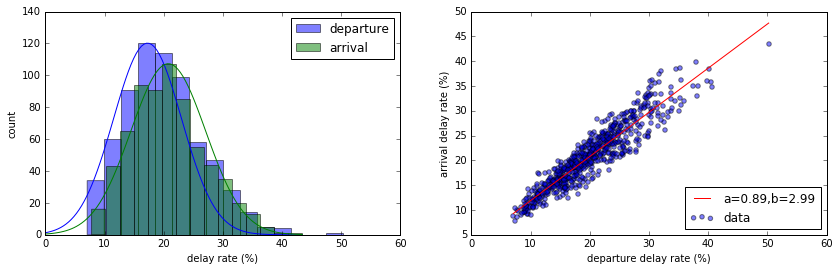

Correlation between departure and arrival delay rates: 0.934545927748


In [295]:
# generate histograms of dep and arr delays one next to each other to compare the median and standard deviation
dep_del_rate = 100*df_date_carrier.NUM_DEP_DEL15/df_date_carrier.NUM_FLIGHTS
arr_del_rate = 100*df_date_carrier.NUM_ARR_DEL15/df_date_carrier.NUM_FLIGHTS

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (14,4))
ax1.hist(dep_del_rate,15,alpha=0.5)
ax1.hist(arr_del_rate,15,alpha=0.5)
ax1.set_xlabel('delay rate (%)')
ax1.set_ylabel('count')
ax1.legend(['departure','arrival'])

# Can these distributions be fitted to Gaussian? If yes, then they are random
from scipy.stats import norm
dep_param = norm.fit(dep_del_rate)
xx = np.linspace(0,max(dep_del_rate),100)
dep_fitted = norm.pdf(xx,loc=dep_param[0],scale=dep_param[1])

arr_param = norm.fit(arr_del_rate)
xx = np.linspace(0,max(arr_del_rate),100)
arr_fitted = norm.pdf(xx,loc=arr_param[0],scale=arr_param[1])

ax1.plot(xx, dep_fitted*2E3,'b-')
ax1.plot(xx, arr_fitted*1.7E3,'g-')


ax2.scatter(dep_del_rate,arr_del_rate,alpha=0.5)
ax2.set_xlabel('departure delay rate (%)')
ax2.set_ylabel('arrival delay rate (%)')

# fit scatter data
a,b = spo.curve_fit(lambda x,a,b:a*x+b,dep_del_rate,arr_del_rate)[0]
plt.plot(np.linspace(min(dep_del_rate),max(dep_del_rate),100),
         a*np.linspace(min(dep_del_rate),max(dep_del_rate),100)+b,'r')
plt.legend(['a={0},b={1}'.format(round(a,2),round(b,2)),'data'],loc=4)
plt.show()



print "Correlation between departure and arrival delay rates:", dep_del_rate.corr(arr_del_rate)

In general, US domestic flights are about 15% likely to take off with 15 minutes of delay while they are 20% likely to arrive with 15 minutes of delay. Both departure and arrival delay rates are strong correlated with a strength of 0.93. So, in future analysis, we will focus only on arrival delay rates and therefore any insight on departure delays can be deducted from arrival delay rates

#### Can we use historical info on delay rates to predict future delay rates?
Let's try to build a model that will use the carrier name, previous month delay rate and the change in delay rates of the last two month

In [392]:

df_data = pd.DataFrame()
for carrier in major_carriers:
    df = df_date_carrier[df_date_carrier.CARRIER == carrier].sort_values('DATE').reset_index()
    tmp = pd.DataFrame()
    if df.shape[0] > 0:
        #print carrier,df.shape
        adr = 100*df.NUM_ARR_DEL15/df.NUM_FLIGHTS
        tmp['DATE'] = df[2:]['DATE']
        tmp['MONTH'] = tmp.DATE.apply(lambda x:x.month)
        tmp['CARRIER'] = carrier
        tmp['ADR_CHANGE'] = adr[1:-1].values - adr[:-2].values
        tmp['ADR_PREV'] = adr[1:-1].values
        tmp['ADR'] = adr[2:].values
        df_data = df_data.append(tmp, ignore_index=True)


#### Predictive Model Building
Here we are going to use sklearn and try to build a model that would predict the probability of arrivals being delayed by 15min+

In [434]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


In [512]:
# prepare labels
labels_train = ['MONTH','CARRIER','ADR_CHANGE','ADR_PREV']
labels_target = df_data.columns[-1]

# convert carrier string variable to numeric variables
le_carrier = LabelEncoder()
df_data['CARRIER'] = le_carrier.fit_transform(df_data.CARRIER.astype('str'))

Split data into train, validation and test sets

In [513]:
df_train = df_data[df_data.DATE<dt.datetime(2014,1,1).date()]
df_valid = df_data[(df_data.DATE>=dt.datetime(2014,1,1).date()) & (df_data.DATE<dt.datetime(2015,1,1).date())]
df_test = df_data[(df_data.DATE>=dt.datetime(2015,1,1).date()) & (df_data.DATE<dt.datetime(2016,1,1).date())]

In [514]:
print "Random Forest Regressor"
rfrmodel = RandomForestRegressor(n_estimators=20, max_features=2)
rfrmodel.fit(df_train[labels_train],df_train[labels_target])
yvalid = rfrmodel.predict(df_valid[labels_train])
ytest = rfrmodel.predict(df_test[labels_train])

print "mse score on training set:", mean_squared_error(df_train[labels_target],rfrmodel.predict(df_train[labels_train]))
print "mse score on validation set:", mean_squared_error(df_valid[labels_target],yvalid)
print "mse score on test set:", mean_squared_error(df_test[labels_target],ytest)

Random Forest Regressor
mse score on training set: 2.95048505358
mse score on validation set: 15.4484641889
mse score on test set: 16.1139400737


In [517]:
print "xgboost"
xgbmodel = XGBRegressor(n_estimators=20)
xgbmodel.fit(df_train[labels_train],df_train[labels_target])
yvalid = xgbmodel.predict(df_valid[labels_train])
ytest = xgbmodel.predict(df_test[labels_train])

print "mse score on training set:", mean_squared_error(df_train[labels_target],xgbmodel.predict(df_train[labels_train]))
print "mse score on validation set:", mean_squared_error(df_valid[labels_target],yvalid)
print "mse score on test set:", mean_squared_error(df_test[labels_target],ytest)

xgboost
mse score on training set: 22.9848694989
mse score on validation set: 26.4819829551
mse score on test set: 21.5708447212


#### Time series statistical analayis

1. Make the time series stationary

2. Remove trend and seasonality (to remain with residuals)

3. Use ARIMA for forecasting

Let's start by checking for stationarity using **Dickey-Fuller Test** which tests the null hypothesis of whether a unit root is present in a time series sample. 
http://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

In [572]:
df_train = df_date_carrier[df_date_carrier.DATE<dt.datetime(2015,1,1).date()]
df_valid = df_date_carrier[(df_date_carrier.DATE>=dt.datetime(2015,1,1).date()) & (df_date_carrier.DATE<dt.datetime(2016,1,1).date())]

In [641]:
#Time series analysis
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts_data, xvals = None, window=2):
    if type(xvals) != pd.core.series.Series:
        xvals = ts_data.index
    # calculate rolling stats
    roll_mean = pd.rolling_mean(ts_data,window = window)
    roll_std = pd.rolling_std(ts_data, window = window)
    
    # plot rolling stats
    fig = plt.figure(figsize = (10,5))
    orig_plt = plt.plot(xvals,ts_data,'b', label = 'original')
    mean_plt = plt.plot(xvals,roll_mean, 'g', label = 'rolling mean')
    std_plt = plt.plot(xvals,roll_std, 'r', label = 'rolling std')
    plt.legend(loc='best')
    plt.title('rolling mean vs std')
    plt.show()
    
    # Dickey-Fuller test
    print 'Dickey-Fuller Test:'
    dftest = adfuller(ts_data.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

In [731]:
carrier = 'B6'
dd1 = pd.DataFrame(100*df_train[df_train.CARRIER == carrier]['NUM_ARR_DEL15']/df_train[df_train.CARRIER == carrier]['NUM_FLIGHTS'])
dd1 = 100*df_train[df_train.CARRIER == carrier]['NUM_ARR_DEL15']/df_train[df_train.CARRIER == carrier]['NUM_FLIGHTS']
#dd1.index = df_date_carrier.loc[dd1.index,'DATE']

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:8: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:9: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).std()



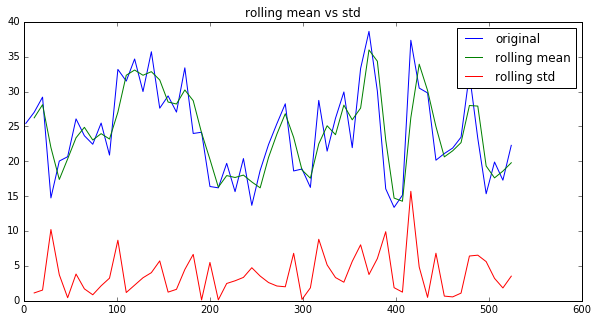

Dickey-Fuller Test:
Test Statistic                 -4.714473
p-value                         0.000079
#Lags Used                      0.000000
Number of Observations Used    58.000000
Critical Value (5%)            -2.912837
Critical Value (1%)            -3.548494
Critical Value (10%)           -2.594129
dtype: float64


In [732]:
test_stationarity(dd1)#,xvals=df_train[df_train.CARRIER == carrier]['DATE'],window=2)

With the test statistics less than 0.05, we can say that our time series is already stationary with 95% confidence

#### Eliminating seasonality
Here we use differencing techniques to get rid off any seasonality and trend and hence remain with only residuals

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:8: FutureWarning:

pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).mean()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel-4.0.3-py2.7.egg/ipykernel/__main__.py:9: FutureWarning:

pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=2,center=False).std()



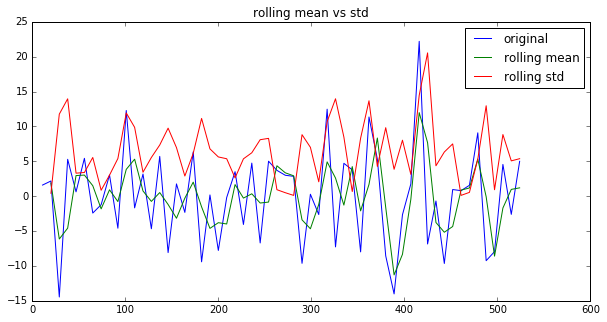

Dickey-Fuller Test:
Test Statistic                -7.076406e+00
p-value                        4.789360e-10
#Lags Used                     3.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (5%)           -2.916770e+00
Critical Value (1%)           -3.557709e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [733]:
ts_diff = dd1 - dd1.shift()
ts_diff.dropna(inplace=True)
test_stationarity(ts_diff, window=2)

In [606]:
from statsmodels.tsa.stattools import acf, pacf

In [734]:
lag_acf = acf(ts_diff, nlags=10)
lag_pacf = pacf(ts_diff, nlags=10)#, method='ols')

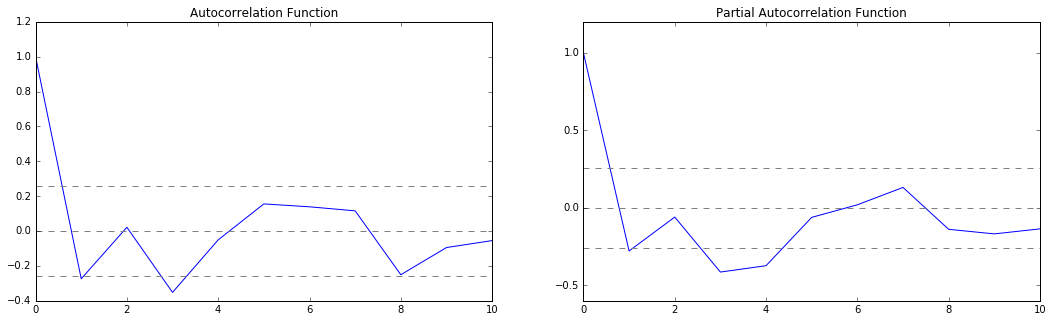

In [735]:
#Plot ACF: 
fig, (ax1,ax2)=plt.subplots(1,2, figsize = (18,5))
#plt.subplot(121) 
ax1.plot(lag_acf)
ax1.axhline(y=0,linestyle='--',color='gray')
ax1.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax1.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax1.set_title('Autocorrelation Function')

#Plot PACF:
ax2.plot(lag_pacf)
ax2.axhline(y=0,linestyle='--',color='gray')
ax2.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax2.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
ax2.set_title('Partial Autocorrelation Function')

For ARIMA, we are going to use p=0.5, q=0.5

In [632]:
from statsmodels.tsa.arima_model import ARIMA

mse score on validation set: 28.8819929701


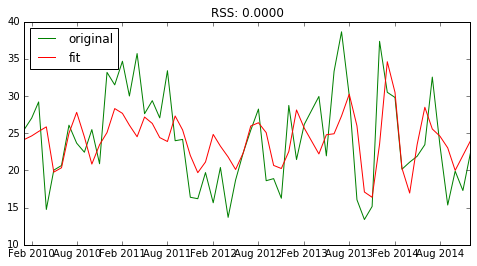

In [736]:
# ARIMA Model
dd1_df = pd.DataFrame(dd1)
df_ts_diff = pd.DataFrame(ts_diff)
#dd1_df.index = df_date_carrier.loc[dd1.index,'DATE'].values
dd1_df.index = map(lambda x:dt.datetime(x.year,x.month,x.day),df_date_carrier.loc[dd1.index,'DATE'])
df_ts_diff.index = map(lambda x:dt.datetime(x.year,x.month,x.day),df_date_carrier.loc[ts_diff.index,'DATE'])
model = ARIMA(dd1_df, order=(3, 0, 3))  
results_AR = model.fit()  
fig = plt.figure(figsize=(8,4))
#plt.plot(df_ts_diff,label='difference')
plt.plot(dd1_df,'g', label='original')
plt.plot(results_AR.fittedvalues, color='red', label='fit')
plt.title('RSS: %.4f'% np.nansum((results_AR.fittedvalues-ts_diff)**2))
plt.legend(loc='best')
print "mse score on validation set:", mean_squared_error(dd1_df,results_AR.fittedvalues)

In [685]:
model.fit?

In [3]:
tmp = pd.read_csv('data/2010/208712471_T_ONTIME-1.csv')

In [4]:
tmp.columns

Index([u'YEAR', u'QUARTER', u'MONTH', u'DAY_OF_MONTH', u'DAY_OF_WEEK',
       u'FL_DATE', u'UNIQUE_CARRIER', u'AIRLINE_ID', u'CARRIER', u'TAIL_NUM',
       u'FL_NUM', u'ORIGIN_AIRPORT_ID', u'ORIGIN_AIRPORT_SEQ_ID',
       u'ORIGIN_CITY_MARKET_ID', u'ORIGIN', u'ORIGIN_CITY_NAME',
       u'ORIGIN_STATE_ABR', u'ORIGIN_STATE_FIPS', u'ORIGIN_STATE_NM',
       u'ORIGIN_WAC', u'DEST_AIRPORT_ID', u'DEST_AIRPORT_SEQ_ID',
       u'DEST_CITY_MARKET_ID', u'DEST', u'DEST_CITY_NAME', u'DEST_STATE_ABR',
       u'DEST_STATE_FIPS', u'DEST_STATE_NM', u'DEST_WAC', u'CRS_DEP_TIME',
       u'DEP_TIME', u'DEP_DELAY', u'DEP_DELAY_NEW', u'DEP_DEL15',
       u'DEP_DELAY_GROUP', u'DEP_TIME_BLK', u'TAXI_OUT', u'WHEELS_OFF',
       u'WHEELS_ON', u'TAXI_IN', u'CRS_ARR_TIME', u'ARR_TIME', u'ARR_DELAY',
       u'ARR_DELAY_NEW', u'ARR_DEL15', u'ARR_DELAY_GROUP', u'ARR_TIME_BLK',
       u'CANCELLED', u'CANCELLATION_CODE', u'DIVERTED', u'CRS_ELAPSED_TIME',
       u'ACTUAL_ELAPSED_TIME', u'AIR_TIME', u'FLIGHTS', u'DISTA